In [1]:
# Import required packages
import pandas as pd
import numpy as np
import warnings
import re

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
mpl.style.use('ggplot')
import gc
import geopandas as gpd
from shapely.geometry import Point, Polygon

#Modelling
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_colwidth', None)

In [2]:
file_path = file_path = '../project_data/'
#Energy related
df_solar = pd.read_csv(file_path + 'solar_cleaned.csv')
df_water = pd.read_csv(file_path + 'water_cleaned.csv')
df_electricity = pd.read_csv(file_path + 'electricity_cleaned.csv')
df_gas = pd.read_csv(file_path + 'gas_cleaned.csv')
df_hotwater = pd.read_csv(file_path + 'hotwater_cleaned.csv')
df_irrigation = pd.read_csv(file_path + 'irrigation_cleaned.csv')
df_chilledwater = pd.read_csv(file_path + 'chilledwater_cleaned.csv')
df_steam = pd.read_csv(file_path + 'steam_cleaned.csv')

#Metadata
df_metadata = pd.read_csv(file_path + 'metadata.csv')

#Weather
df_weather = pd.read_csv(file_path + 'weather.csv')

In [3]:
# Keep only buildings of the top 5 regions in our dataset:
df_metadata = df_metadata[df_metadata["timezone"].isin(["US/Eastern", "US/Central", "Europe/London", "US/Mountain", "US/Pacific"])]


# Reformat the meters dataframes first

def melt_meter_dataframes (df, meter_name):
  #timestamp into datetime
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  # Melt the DataFrame: columns become rows under 'building_id', and their values go under 'meter_reading'
  df = df.melt(
      id_vars=["timestamp"],              # Columns to keep as is
      var_name="building_id",             # Name for the new column with former column names
      value_name="meter_reading"          # Name for the new column with values from the original DataFrame
      )

  # Add the 'meter' column
  df["meter"] = meter_name

  # Rearrange columns for clarity
  df = df[["timestamp", "building_id", "meter", "meter_reading"]]

  return df

df_electricity = melt_meter_dataframes(df_electricity, "electricity")
df_gas = melt_meter_dataframes(df_gas, "gas")
df_hotwater = melt_meter_dataframes(df_hotwater, "hotwater")
df_chilledwater = melt_meter_dataframes(df_chilledwater, "chilledwater")
df_steam = melt_meter_dataframes(df_steam, "steam")
df_water = melt_meter_dataframes(df_water, "water")
df_irrigation = melt_meter_dataframes(df_irrigation, "irrigation")
df_solar = melt_meter_dataframes(df_solar, "solar")


# Function to reduce the DF size ( https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction)
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Reduce memory
df_metadata = reduce_mem_usage(df_metadata)
gc.collect()

# Concatenate all meters data and then merge it with metadata

# Concatenate all the meter dataframes
meters = pd.concat([df_electricity, df_gas, df_hotwater, df_chilledwater, df_steam, df_water, df_irrigation, df_solar])
meters = reduce_mem_usage(meters)
gc.collect()

# Features from buildings metadata and weather dataset to add to meters dataset 
######### WE ADD MORE FEATURES THAN IN THE EDA ###########
buildings_sel = df_metadata[["building_id","site_id","primaryspaceusage","timezone", 'sqm', 'occupants', 'yearbuilt']]
df_weather_2 = df_weather[["timestamp", "site_id", "airTemperature", "seaLvlPressure","windSpeed"]]

# Join the datasets: meter reading + building metadata
dev = meters.merge(buildings_sel, on="building_id", how = "left")

# Transform timestamp to datetime object type
dev["timestamp"] = pd.to_datetime(dev["timestamp"], format='%Y-%m-%d %H:%M:%S')
df_weather_2["timestamp"] = pd.to_datetime(df_weather_2["timestamp"], format='%Y-%m-%d %H:%M:%S')

# Merge with the weather dataset to add weather data
dev = dev.merge(df_weather_2, on=["timestamp", "site_id"], how="left")

del(meters, buildings_sel, df_metadata, df_weather_2)

Mem. usage decreased to  0.33 Mb (18.9% reduction)
Mem. usage decreased to 1838.90 Mb (10.0% reduction)


C:\Users\jayca\AppData\Local\Temp\ipykernel_3336\2294256471.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather_2["timestamp"] = pd.to_datetime(df_weather_2["timestamp"], format='%Y-%m-%d %H:%M:%S')


Guassian

In [4]:
#create input data
input_df = dev[['timestamp', 'meter', 'meter_reading', "sqm", "occupants", "yearbuilt", "airTemperature", "seaLvlPressure", "windSpeed"]]
cdf = input_df.copy()

#make sure that timestamp is in datetime format
cdf['timestamp'] = pd.to_datetime(cdf['timestamp'])


In [5]:
#create input data
input_df = dev[['timestamp', 'building_id','meter', 'meter_reading', "sqm", "occupants", "yearbuilt", "airTemperature", "seaLvlPressure", "windSpeed", "timezone"]]
cdf = input_df.copy()

#make sure that timestamp is in datetime format
cdf['timestamp'] = pd.to_datetime(cdf['timestamp'])

#replace with 0 if a reading is missing:
cdf['meter_reading'] = cdf['meter_reading'].fillna(0)

# Aggregating data: group by building_id and hour
cdf["hour"] = cdf["timestamp"].dt.hour
features = cdf.groupby(["timezone","building_id", "hour"])[["meter_reading"]].median().unstack(fill_value=0)

# Reset index for clustering
features = features.reset_index()
features.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in features.columns]

# Normalization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features.iloc[:, 2:])  # Skip building_id and timezone columns


Missing values in 'yearbuilt': 0


C:\Users\jayca\AppData\Local\Temp\ipykernel_3336\1380331399.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for year_range, yr_df in cdf.groupby("year_range"):


Processing year range: 1900-1920


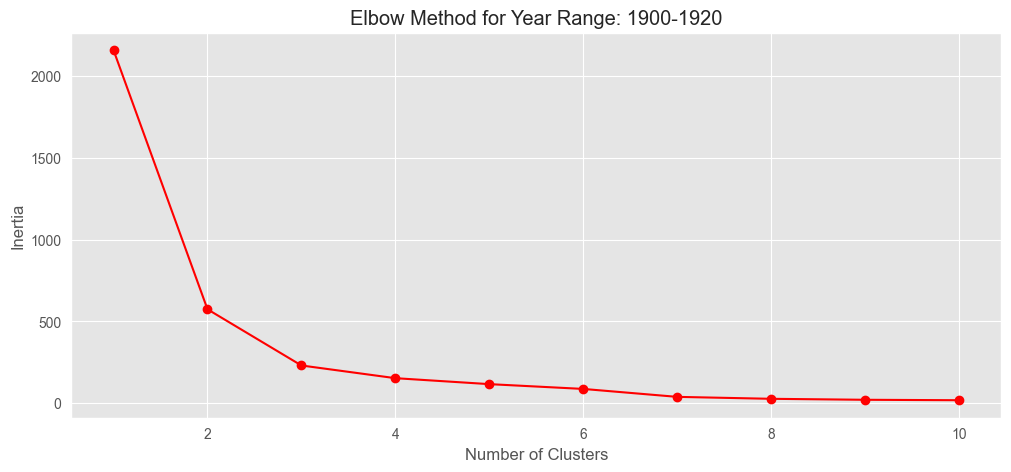

Processing year range: 1921-1940


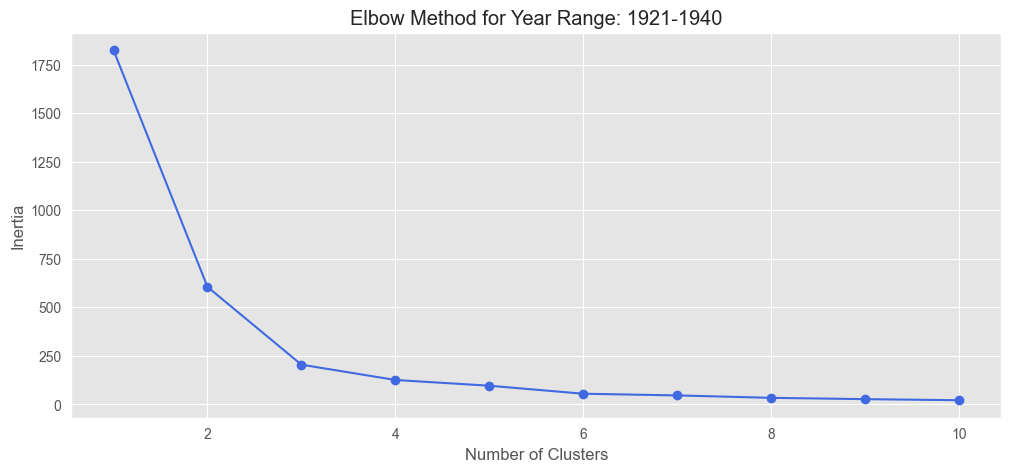

Processing year range: 1941-1960


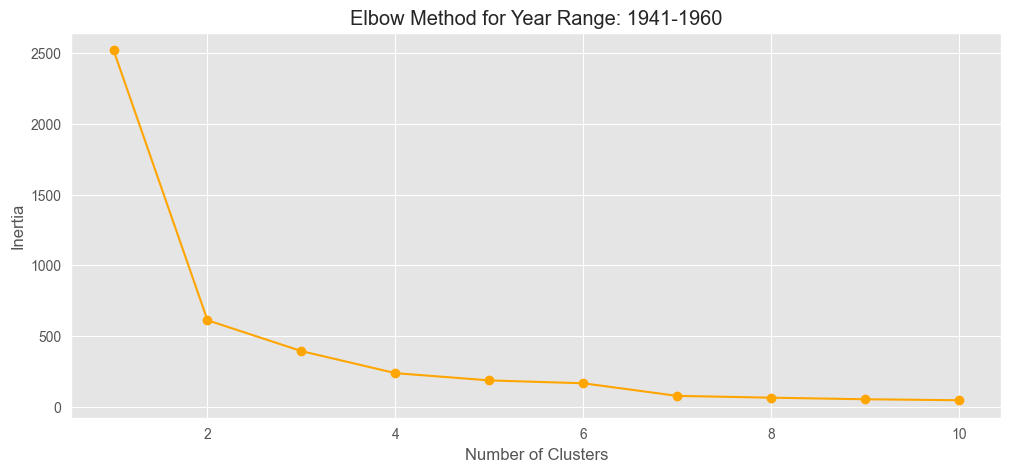

Processing year range: 1961-1980


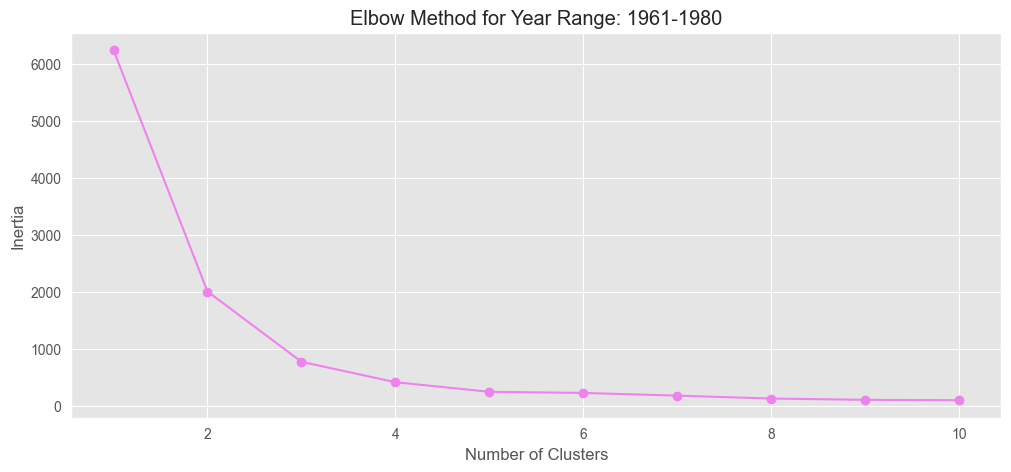

Processing year range: 1981-2000


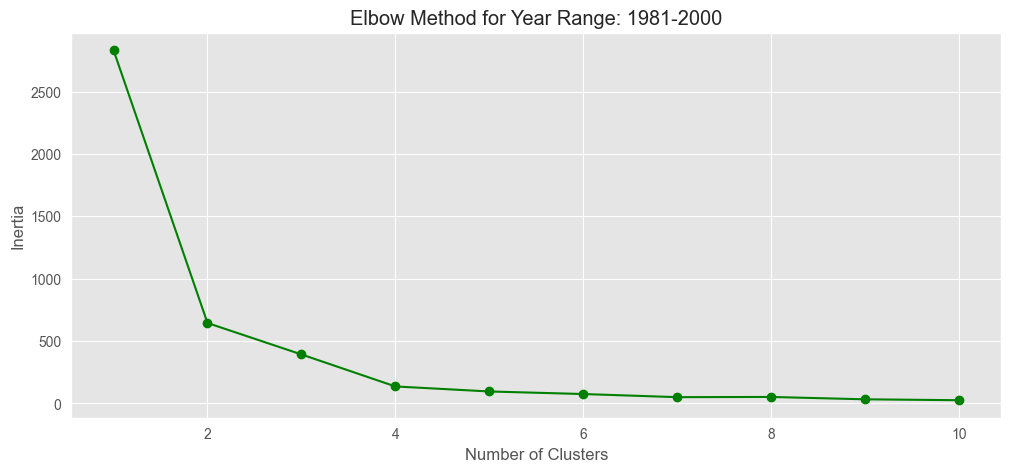

Processing year range: 2001-2020


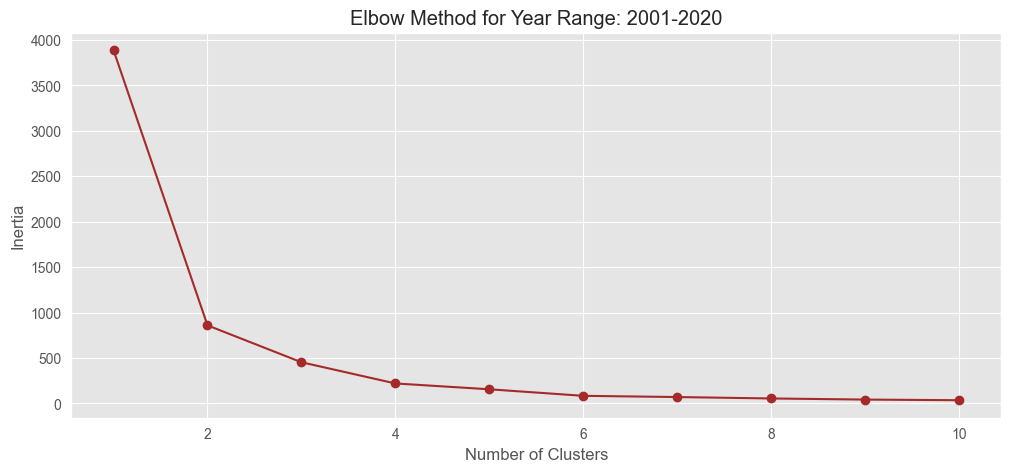

In [7]:
# Define year ranges and labels
year_bins = [1900, 1920, 1940, 1960, 1980, 2000, 2020]
year_labels = ["1900-1920", "1921-1940", "1941-1960", "1961-1980", "1981-2000", "2001-2020"]

# Define colors for each year range
color_map = {
    "1900-1920": "red",
    "1921-1940": "royalblue",
    "1941-1960": "orange",
    "1961-1980": "violet",
    "1981-2000": "green",
    "2001-2020": "brown"
}

# Check for missing values in yearbuilt
na_count = cdf['yearbuilt'].isnull().sum()
print(f"Missing values in 'yearbuilt': {na_count}")

# Drop rows with NaN in yearbuilt
cdf = cdf.dropna(subset=['yearbuilt'])

# Convert yearbuilt to int64
cdf['yearbuilt'] = cdf['yearbuilt'].astype('int64')

# Assign year ranges to buildings based on 'yearbuilt'
cdf['year_range'] = pd.cut(cdf['yearbuilt'], bins=year_bins, labels=year_labels, right=True)

# Function to determine inertia for Elbow Method
def determine_elbow_inertia(features, max_clusters=10):
    inertia = []
    for n_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(features)
        inertia.append(kmeans.inertia_)
    return inertia

# Dictionary to store inertia results per year range
elbow_results = {}

# Loop through each year range
for year_range, yr_df in cdf.groupby("year_range"):
    print(f"Processing year range: {year_range}")

    # Group data by building_id and hour for this year range
    yr_features = yr_df.groupby(["building_id", "hour"])[["meter_reading"]].median().unstack(fill_value=0)
    yr_features = yr_features.reset_index()
    yr_features.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in yr_features.columns]

    # Normalize features (excluding building_id)
    scaler = StandardScaler()
    scaled_yr_features = scaler.fit_transform(yr_features.iloc[:, 1:])  # Skip building_id column

    # Determine inertia for elbow plot
    inertia = determine_elbow_inertia(scaled_yr_features)

    # Plot Elbow Method for this year range
    plt.figure(figsize=(12, 5))
    plt.plot(range(1, len(inertia) + 1), inertia, marker='o', color=color_map[str(year_range)])
    plt.title(f"Elbow Method for Year Range: {year_range}")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()
    
    # Store inertia for analysis
    elbow_results[year_range] = inertia


Based on the elbow plots:

    For Year Range 1900-1920, the elbow appears to be at 2 clusters, as the slope flattens significantly after that.
    For Year Range 1921-1940, the elbow also seems to be at 2 clusters, with minimal improvement beyond this point.
    For Year Range 1941-1960, the elbow seems to occur at 3 clusters, as there is a noticeable bend at this point.
    For Year Range 1961-1980, the optimal number appears to be 2 or 3 clusters, depending on how strict you are about the "flattening."
    For Year Range 1981-2000, 3 clusters might be optimal, as the curve flattens significantly after 3.
    For Year Range 2001-2020, 2 clusters seems to work best.

C:\Users\jayca\AppData\Local\Temp\ipykernel_3336\175308962.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for year_range, yr_df in cdf.groupby("year_range"):


Processing year range: 1900-1920


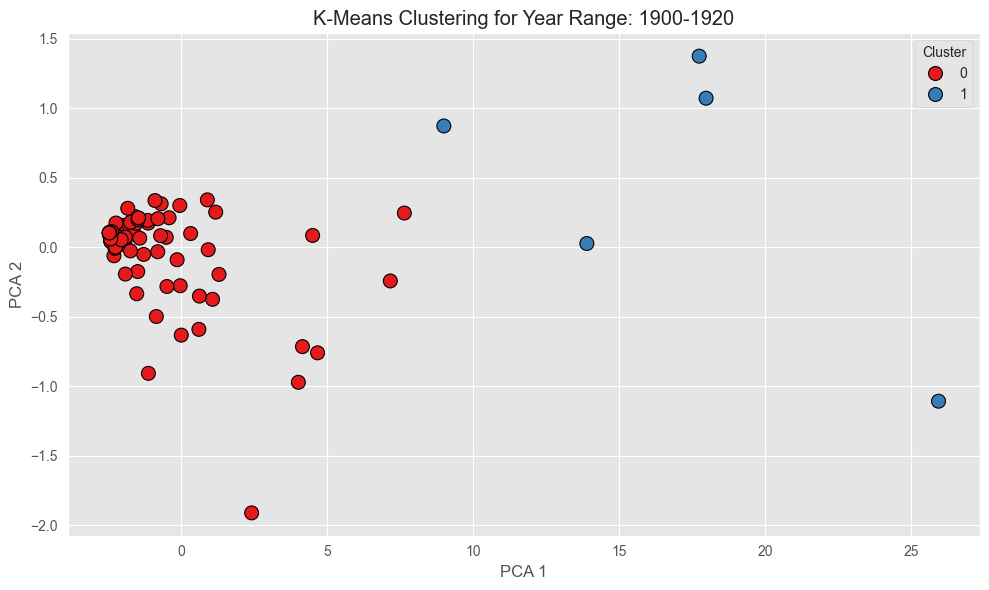

Processing year range: 1921-1940


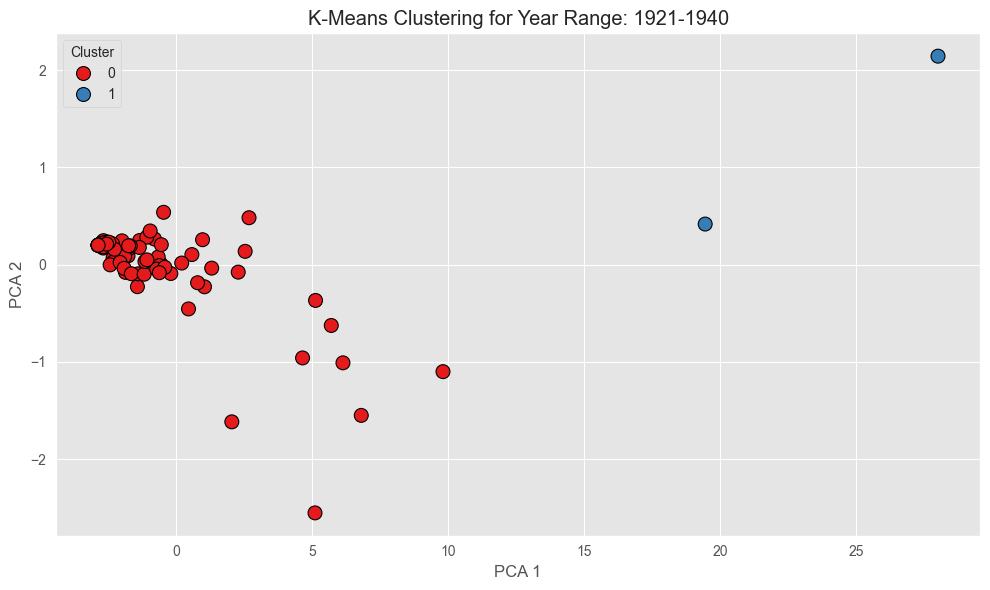

Processing year range: 1941-1960


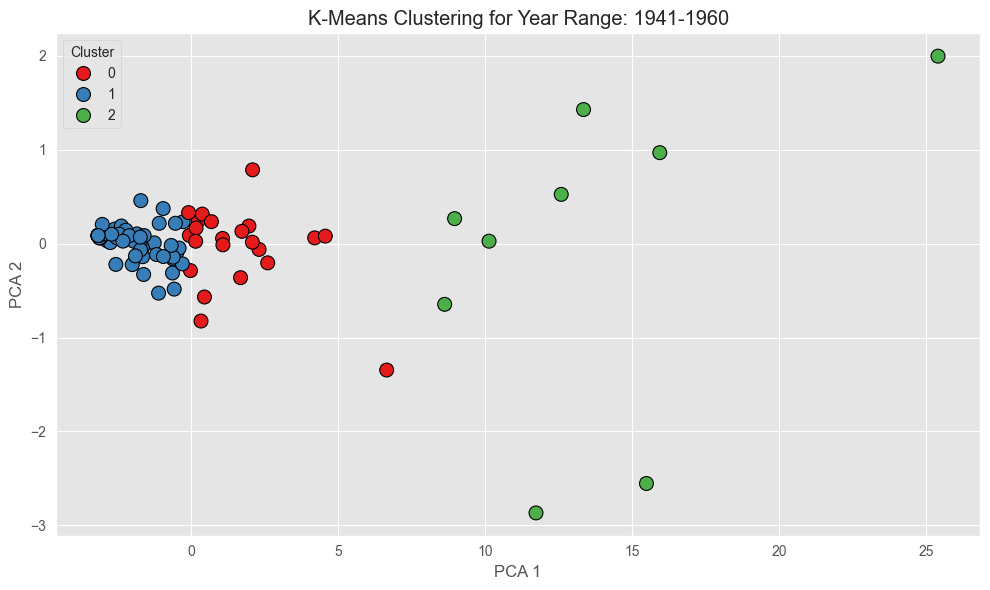

Processing year range: 1961-1980


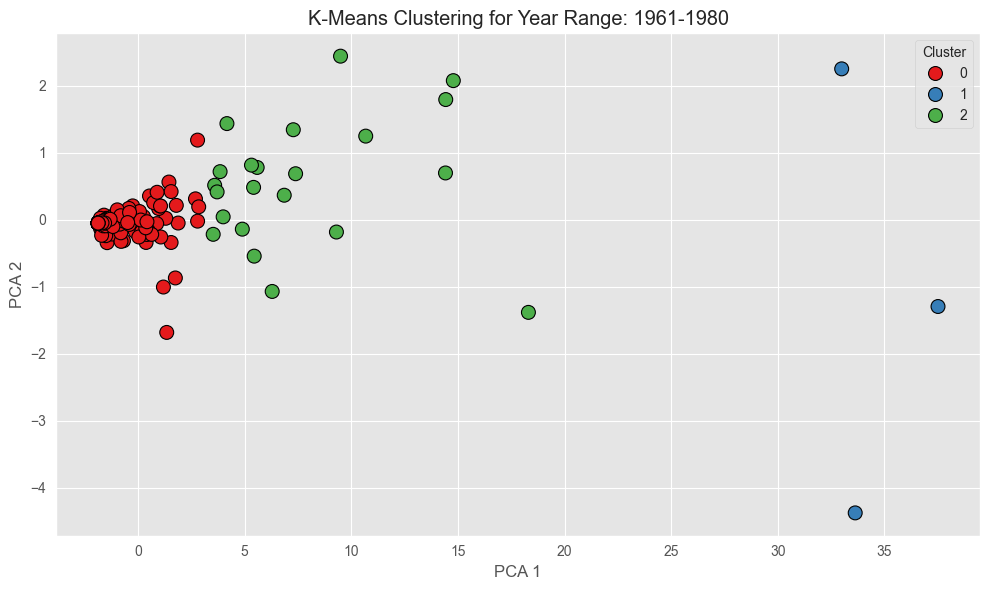

Processing year range: 1981-2000


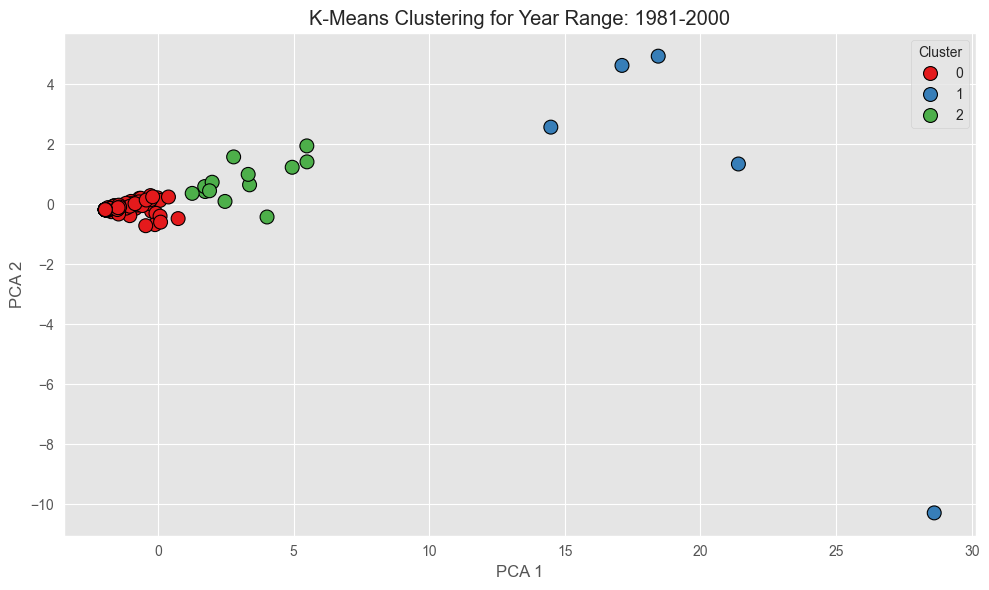

Processing year range: 2001-2020


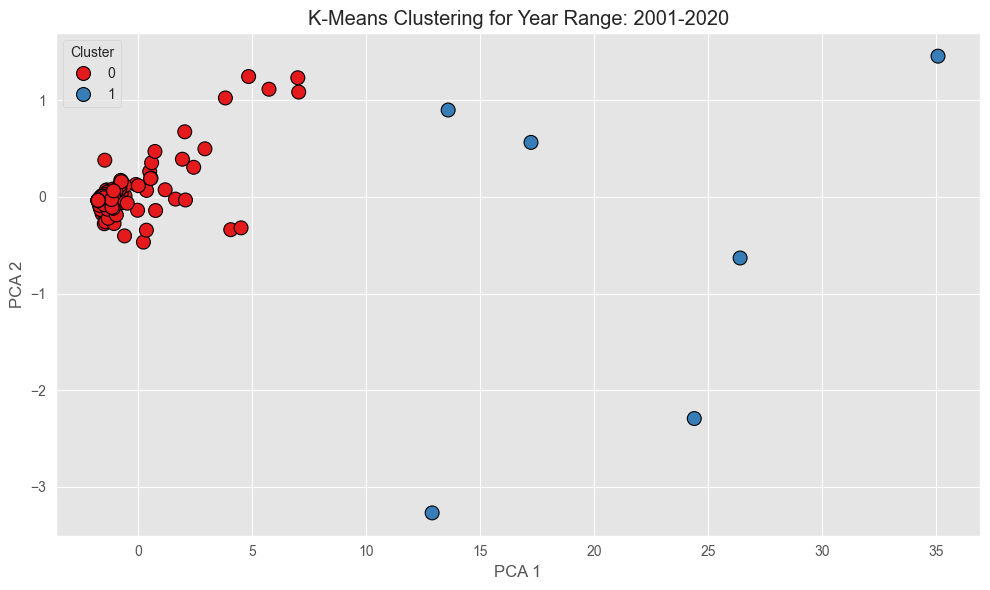

In [10]:
# Loop through each year range
for year_range, yr_df in cdf.groupby("year_range"):
    print(f"Processing year range: {year_range}")

    # Group data by building_id and hour for this year range
    yr_features = yr_df.groupby(["building_id", "hour"])[["meter_reading"]].median().unstack(fill_value=0)
    yr_features = yr_features.reset_index()

    # Flatten multi-index column names
    yr_features.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in yr_features.columns]

    # Ensure only numeric data is used
    yr_features = yr_features.select_dtypes(include=[float, int])

    # Handle missing values
    yr_features.fillna(0, inplace=True)

    # Normalize features (excluding building_id)
    scaler = StandardScaler()
    scaled_yr_features = scaler.fit_transform(yr_features.iloc[:, 1:])  # Skip building_id column

    # Define the number of clusters for each year range
    if year_range == "1900-1920":
        n_clusters = 2
    elif year_range == "1921-1940":
        n_clusters = 2
    elif year_range == "1941-1960":
        n_clusters = 3
    elif year_range == "1961-1980":
        n_clusters = 3
    elif year_range == "1981-2000":
        n_clusters = 3
    elif year_range == "2001-2020":
        n_clusters = 2
    else:
        n_clusters = 4  # Default if needed

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    yr_features["Cluster"] = kmeans.fit_predict(scaled_yr_features)

    # Apply PCA for dimensionality reduction (reduce to 2D)
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(scaled_yr_features)

    # Create a DataFrame with PCA components and cluster labels
    pca_df = pd.DataFrame(pca_components, columns=["PCA1", "PCA2"])
    pca_df["Cluster"] = yr_features["Cluster"]

    # Visualize the clusters in a 2D scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x="PCA1", y="PCA2", hue="Cluster", data=pca_df,
        palette="Set1", s=100, edgecolor='k', marker='o'
    )
    plt.title(f"K-Means Clustering for Year Range: {year_range}")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()


t-SNE

year_range
1961-1980    8526384
2001-2020    5280744
1981-2000    3929856
1941-1960    2964936
1900-1920    2578968
1921-1940    1964928
Name: count, dtype: int64
Processing year range: 1900-1920


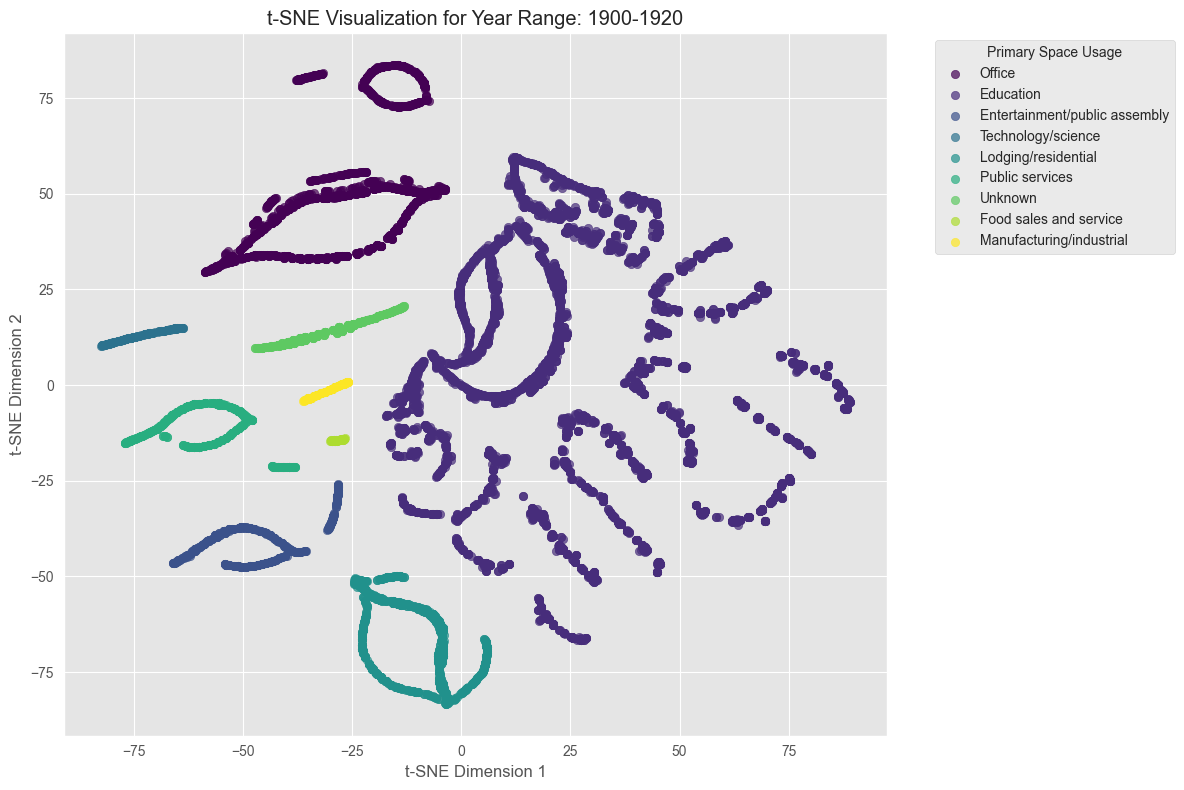

Processing year range: 1921-1940


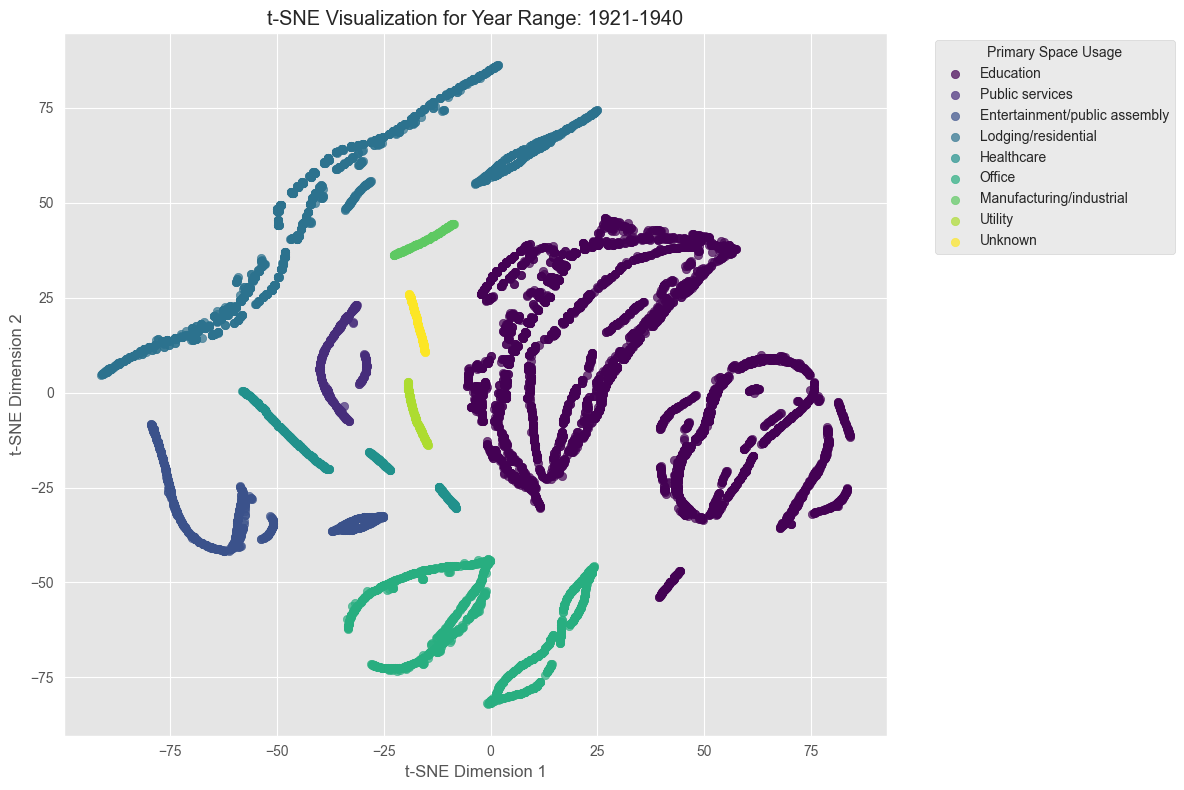

Processing year range: 1941-1960


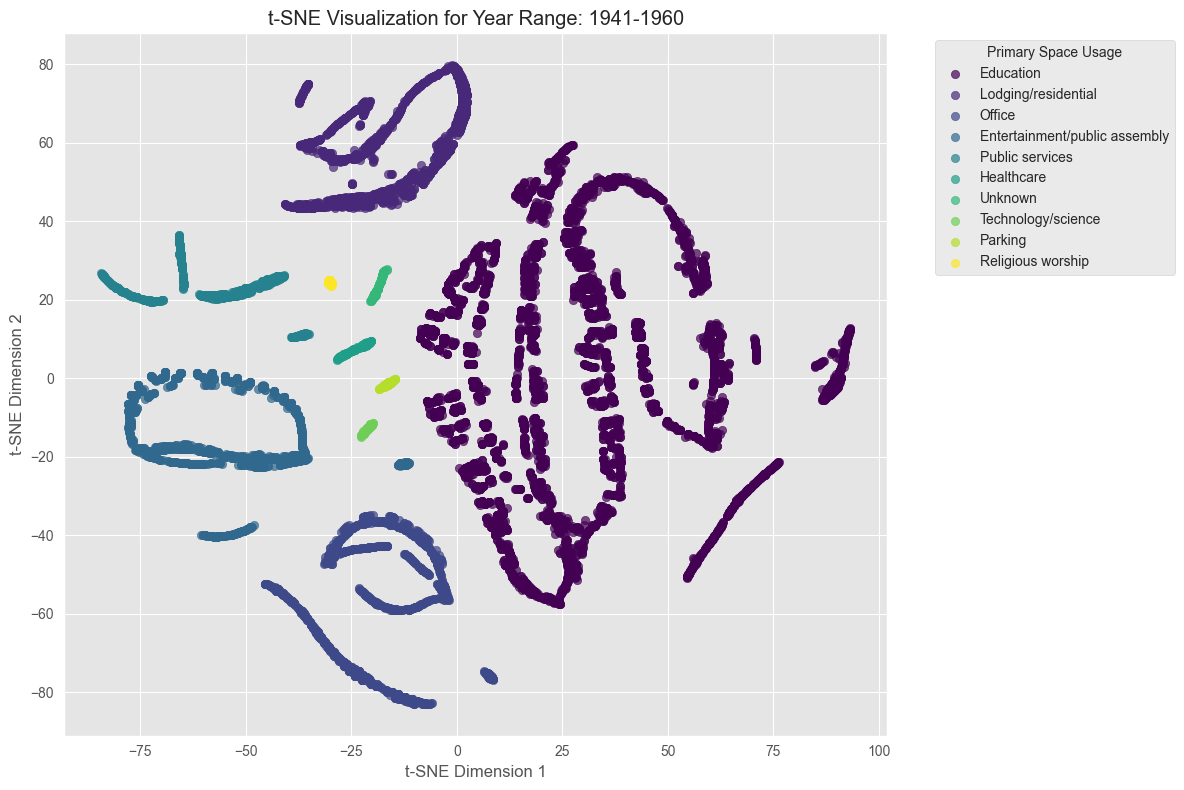

Processing year range: 1961-1980


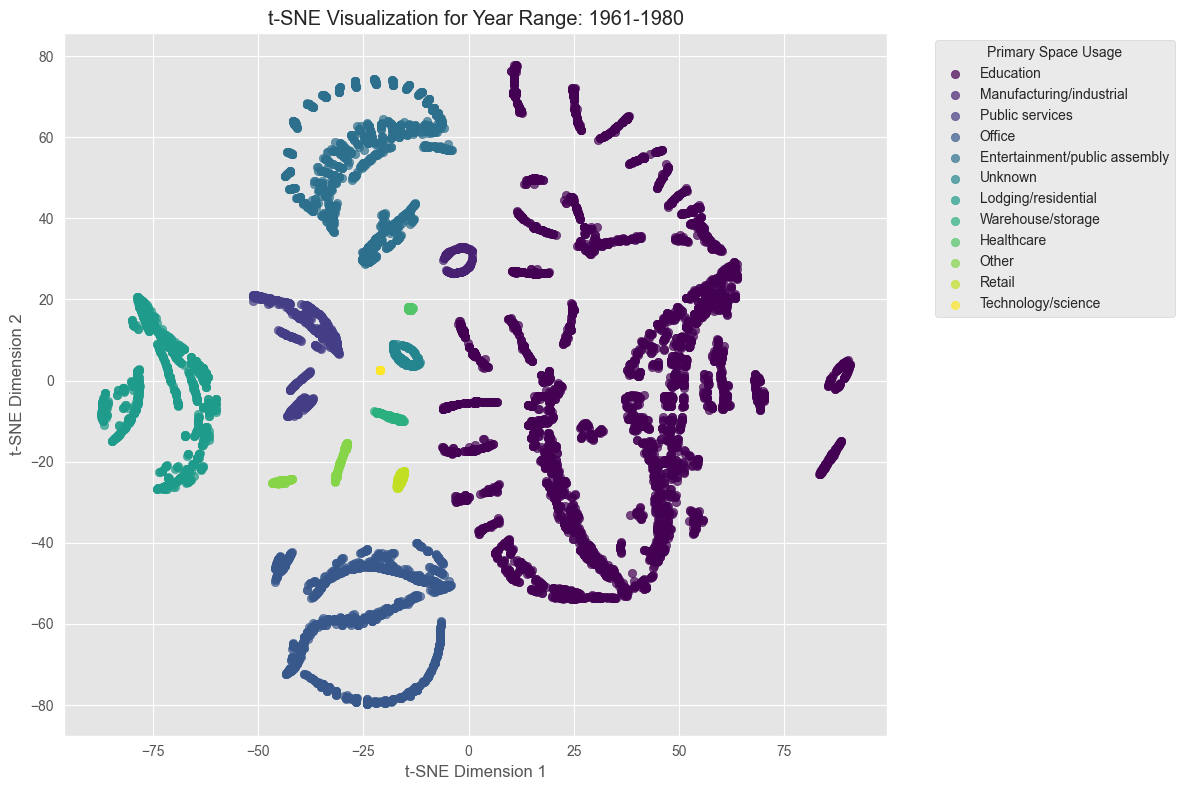

Processing year range: 1981-2000


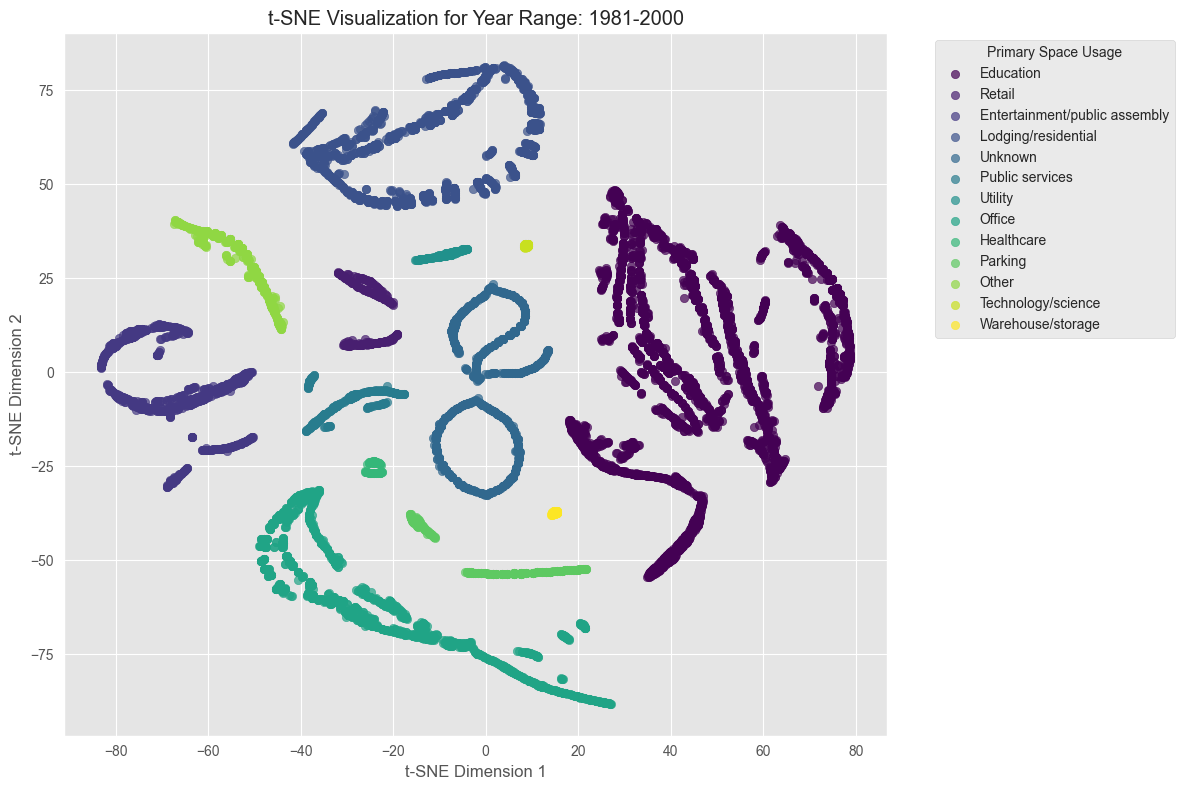

Processing year range: 2001-2020


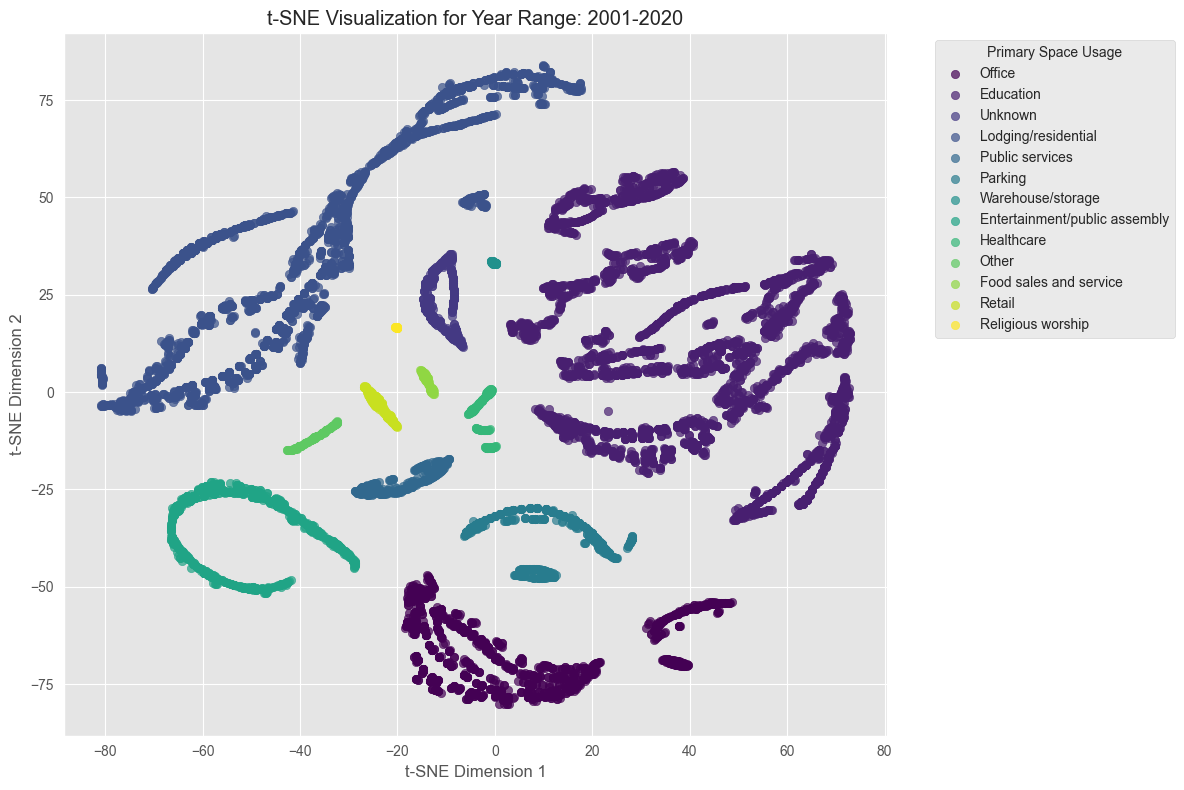

In [19]:
# t-SNE Visualization for Year Ranges

# Remove warnings
warnings.filterwarnings("ignore")

# Ensure yearbuilt is in the correct format and handle missing or infinite values
dev['yearbuilt'] = dev['yearbuilt'].fillna(1900)  # Replace NaN with 1900
dev['yearbuilt'] = dev['yearbuilt'].replace([float('inf'), -float('inf')], 1900)  # Replace infinite values
dev['yearbuilt'] = dev['yearbuilt'].astype('int64')  # Convert yearbuilt to int64

# Assign year_range based on yearbuilt
year_bins = [1900, 1920, 1940, 1960, 1980, 2000, 2020]
year_labels = ["1900-1920", "1921-1940", "1941-1960", "1961-1980", "1981-2000", "2001-2020"]
dev['year_range'] = pd.cut(dev['yearbuilt'], bins=year_bins, labels=year_labels, right=True)

# Drop rows where year_range is NaN
dev = dev.dropna(subset=['year_range'])

# Limit the data size to 10,000 samples per year range for performance
dev_subset = dev.groupby('year_range', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 10000), random_state=42)
)

# Check the distribution of year ranges
print(dev['year_range'].value_counts())

# Select relevant columns
dev_subset = dev_subset[["primaryspaceusage", "meter_reading", "timestamp", "year_range", "sqm", "airTemperature"]]

# Create a mapping of index to primaryspaceusage
primaryspaceusage_map = dev_subset['primaryspaceusage'].to_dict()

# Handle missing values in numeric columns
numeric_columns = ['meter_reading', 'airTemperature', "sqm"]
median_values = dev_subset[numeric_columns].median()
dev_subset[numeric_columns] = dev_subset[numeric_columns].fillna(median_values)

# One-hot encode 'primaryspaceusage'
dev_encoded = pd.get_dummies(dev_subset, columns=['primaryspaceusage'], drop_first=False)

# Normalize the numeric columns
scaler = MinMaxScaler()
dev_encoded[numeric_columns] = scaler.fit_transform(dev_encoded[numeric_columns])

# Group by year range and apply t-SNE
for year_range, group in dev_encoded.groupby('year_range'):
    print(f"Processing year range: {year_range}")
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=1000)
    columns_for_tsne = numeric_columns + list(dev_encoded.filter(like='primaryspaceusage_').columns)
    tsne_result = tsne.fit_transform(group[columns_for_tsne])
    
    tsne_df = pd.DataFrame(tsne_result, columns=['tsne_dim_1', 'tsne_dim_2'])
    tsne_df.index = group.index  # Retain the original index
    
    # Add original primaryspaceusage values back using the dictionary
    tsne_df['primaryspaceusage'] = tsne_df.index.map(primaryspaceusage_map)
    tsne_df['primaryspaceusage'] = tsne_df['primaryspaceusage'].fillna('Unknown')  # Handle NaN values
    
    # Plot
    plt.figure(figsize=(12, 8))

    # Map each primaryspaceusage category to a unique color
    categories = tsne_df['primaryspaceusage'].unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))

    # Scatter plot for each category
    for category, color in zip(categories, colors):
        category_points = tsne_df[tsne_df['primaryspaceusage'] == category]
        plt.scatter(category_points['tsne_dim_1'], category_points['tsne_dim_2'], 
                    color=color, label=category, alpha=0.7)

    # Add legend
    plt.legend(title='Primary Space Usage', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add labels and title
    plt.title(f't-SNE Visualization for Year Range: {year_range}')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.show()


Processing year range: 1900-1920


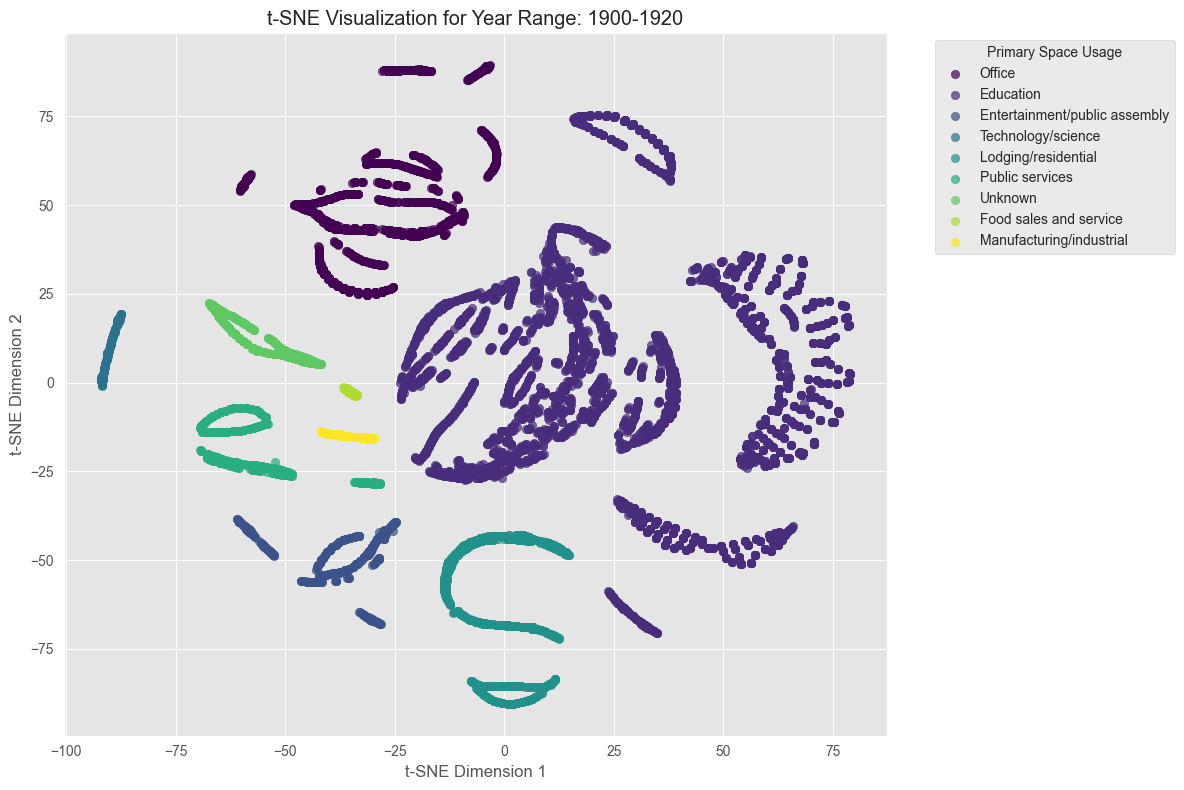

Processing year range: 1921-1940


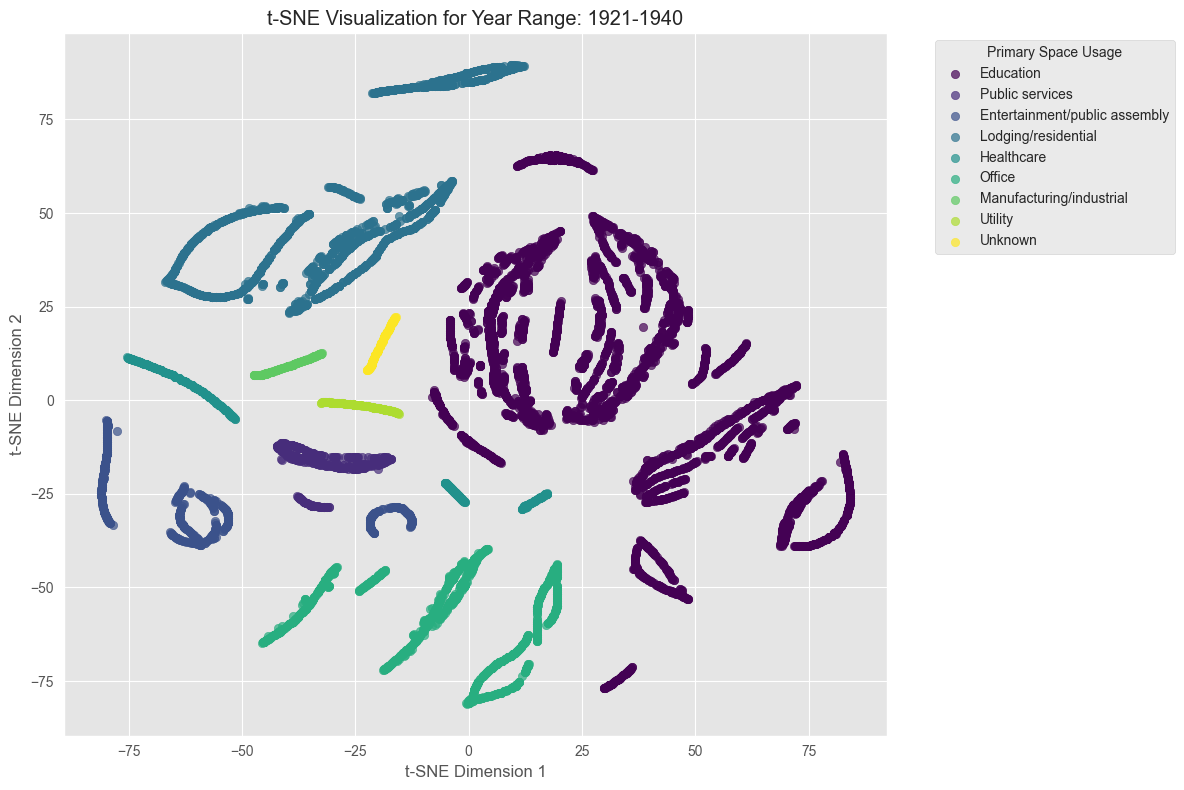

Processing year range: 1941-1960


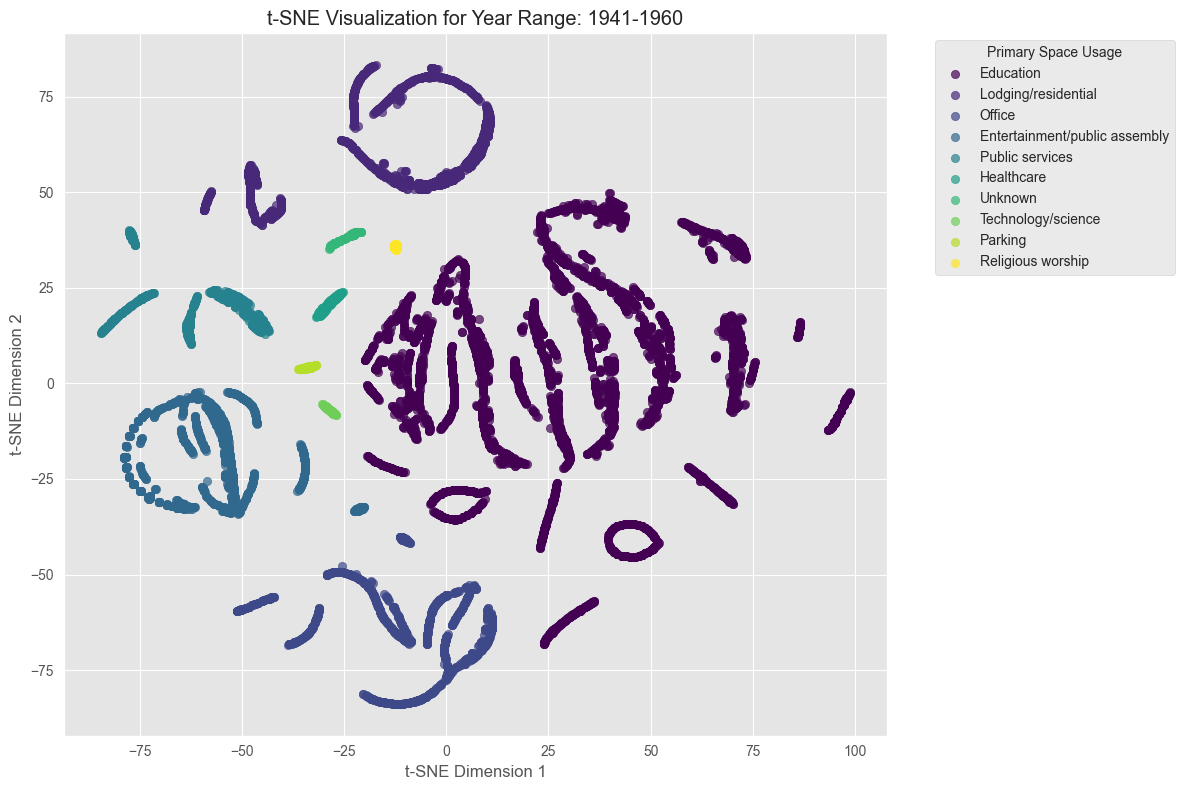

Processing year range: 1961-1980


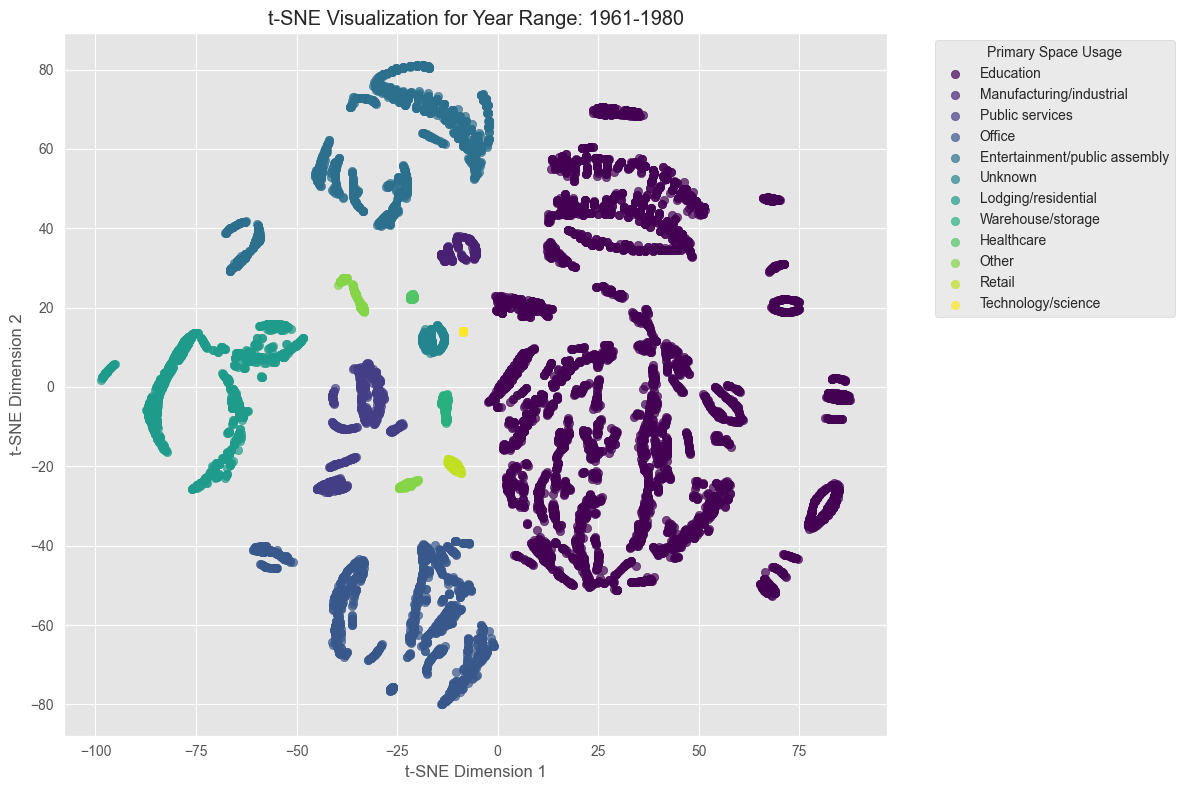

Processing year range: 1981-2000


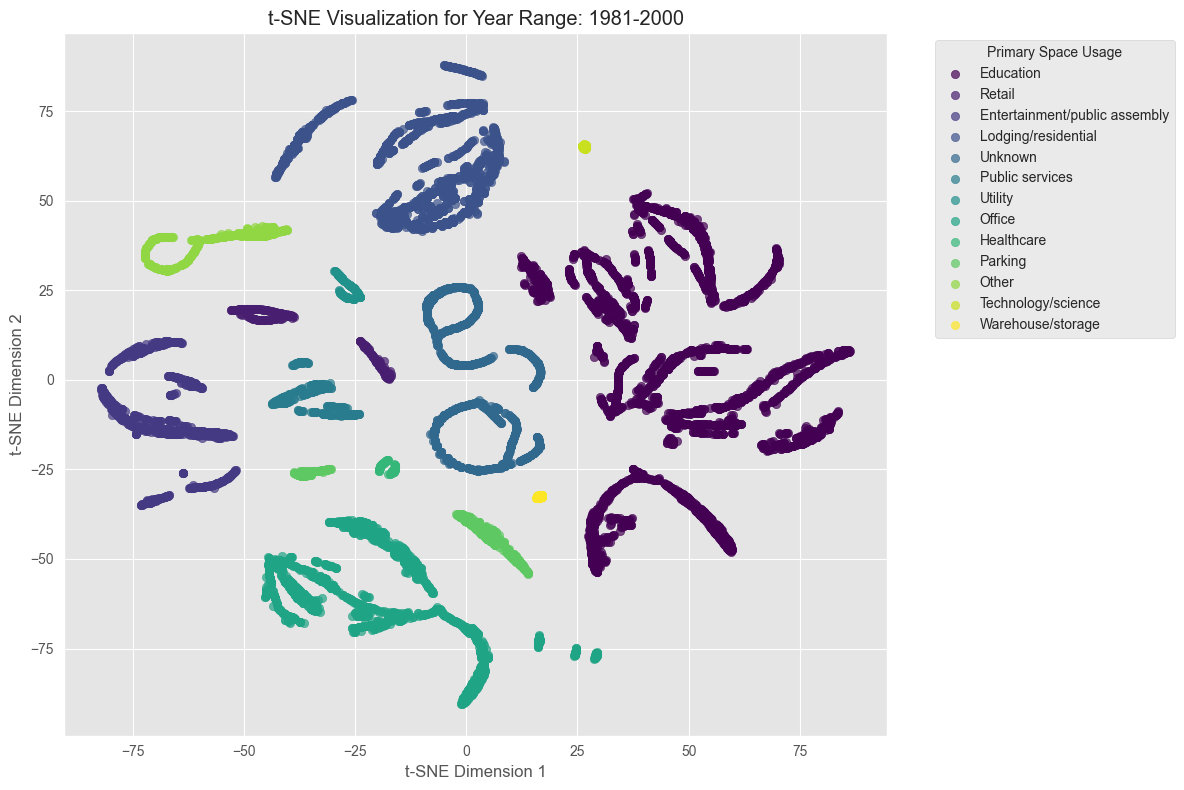

Processing year range: 2001-2020


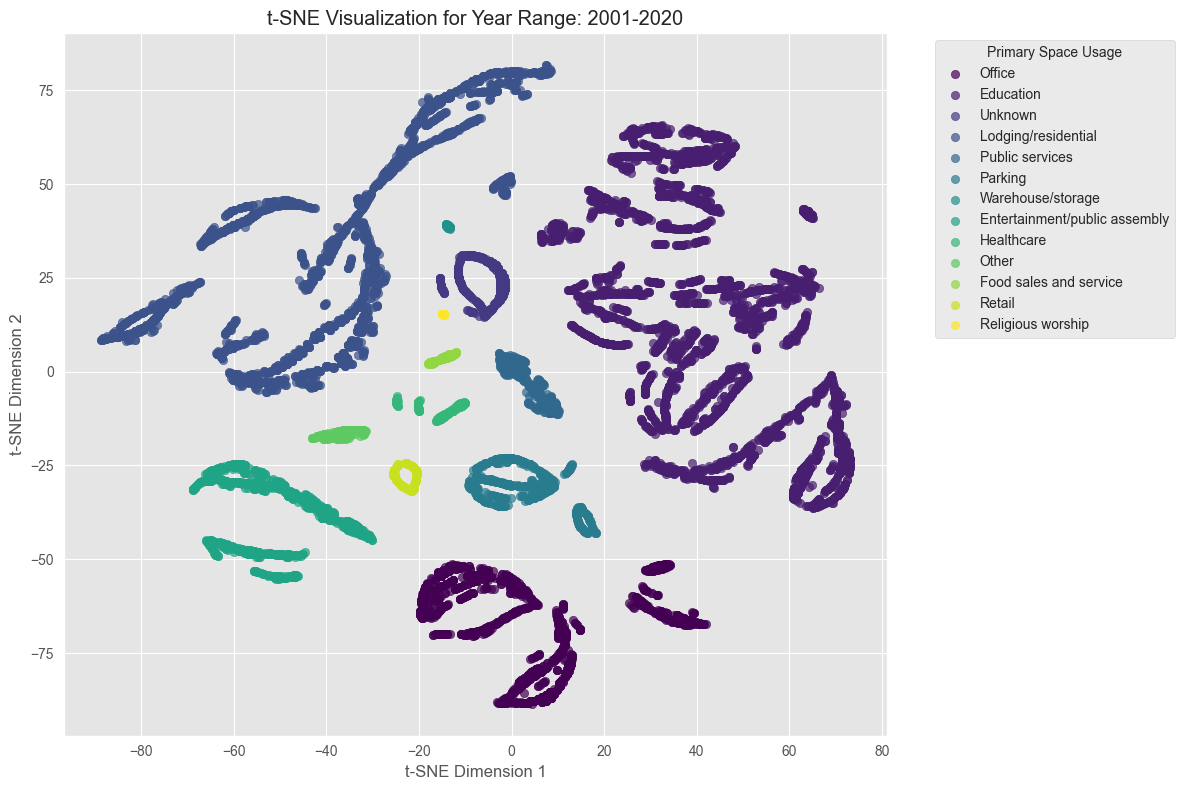

In [21]:
# t-SNE Visualization for Timezones

# Remove warnings
warnings.filterwarnings("ignore")

dev['yearbuilt'] = dev['yearbuilt'].replace([float('inf'), -float('inf')], "")  # Replace infinite values
dev = dev.dropna(subset=['year_range'])
dev['yearbuilt'] = dev['yearbuilt'].astype('int64')  # Convert yearbuilt to int64

# Assign year_range based on yearbuilt
year_bins = [1900, 1920, 1940, 1960, 1980, 2000, 2020]
year_labels = ["1900-1920", "1921-1940", "1941-1960", "1961-1980", "1981-2000", "2001-2020"]
dev['year_range'] = pd.cut(dev['yearbuilt'], bins=year_bins, labels=year_labels, right=True)

# Drop rows where year_range is NaN
dev = dev.dropna(subset=['year_range'])

# Limit the data size to 10,000 samples per year range for performance
dev_subset = dev.groupby('year_range', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 10000), random_state=42)
)

# Select relevant columns
dev_subset = dev_subset[["primaryspaceusage", "meter_reading", "timestamp", "year_range", "sqm", "occupants", "yearbuilt", "airTemperature"]]

# Create a mapping of index to primaryspaceusage
primaryspaceusage_map = dev_subset['primaryspaceusage'].to_dict()

# Handle missing values in numeric columns
numeric_columns = ['meter_reading', 'airTemperature', "sqm", "occupants", "yearbuilt"]
median_values = dev_subset[numeric_columns].median()
dev_subset[numeric_columns] = dev_subset[numeric_columns].fillna(median_values)

# One-hot encode 'primaryspaceusage'
dev_encoded = pd.get_dummies(dev_subset, columns=['primaryspaceusage'], drop_first=False)

# Normalize the numeric columns
scaler = MinMaxScaler()
dev_encoded[numeric_columns] = scaler.fit_transform(dev_encoded[numeric_columns])

# Group by year range and apply t-SNE
for year_range, group in dev_encoded.groupby('year_range'):
    print(f"Processing year range: {year_range}")

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=1000)
    columns_for_tsne = numeric_columns + list(dev_encoded.filter(like='primaryspaceusage_').columns)
    tsne_result = tsne.fit_transform(group[columns_for_tsne])

    tsne_df = pd.DataFrame(tsne_result, columns=['tsne_dim_1', 'tsne_dim_2'])
    tsne_df.index = group.index  # Retain the original index

    # Add original primaryspaceusage values back using the dictionary
    tsne_df['primaryspaceusage'] = tsne_df.index.map(primaryspaceusage_map)
    tsne_df['primaryspaceusage'] = tsne_df['primaryspaceusage'].fillna('Unknown')  # Handle NaN values

    # Plot
    plt.figure(figsize=(12, 8))

    # Map each primaryspaceusage category to a unique color
    categories = tsne_df['primaryspaceusage'].unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))

    # Scatter plot for each category
    for category, color in zip(categories, colors):
        category_points = tsne_df[tsne_df['primaryspaceusage'] == category]
        plt.scatter(category_points['tsne_dim_1'], category_points['tsne_dim_2'], 
                    color=color, label=category, alpha=0.7)

    # Add legend
    plt.legend(title='Primary Space Usage', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add labels and title
    plt.title(f't-SNE Visualization for Year Range: {year_range}')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.show()